In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

C:\tools\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.set_device(0)

SpacePort AI Deep Learning Course Assignment 1

In [4]:
PATH= "data/dogcatbreed/"
sz = 224
arch = resnext101_64
bs = 64

In [5]:
label_csv= f'{PATH}train.csv'
n = len(list(open(label_csv))) - 1 #count row in file, exclude the header row
val_idxs = get_cv_idxs(n) # function choses random 20% data for valdation set

In [6]:
n # the number of items total

7349

In [7]:
len(val_idxs) # the number of items chosen for valdation set

1469

In [8]:
# If you haven't downloaded weights.tgz yet, download the file.
#     http://forums.fast.ai/t/error-when-trying-to-use-resnext50/7555
#     http://forums.fast.ai/t/lesson-2-in-class-discussion/7452/222
#!wget -O fastai/weights.tgz http://files.fast.ai/models/weights.tgz

In [9]:
#!tar xvfz fastai/weights.tgz -C fastai
# If on Windows using Anaconda 3 you must 
# use the explicit path to /fastai/fastai folder as no symlinks 
# and also copy the file resnext_101_64x4d.pth 
# to C:\tools\Anaconda3\envs\fastai\Lib\site-packages\fastai\weights

In [10]:
# !ls {PATH} # For Linux
!Powershell -Command "Get-ChildItem {PATH}" # For windows users



    Directory: C:\Users\nissan.dookeran\Documents\Github\fastai\courses\dl1\data\dogcatbreed


Mode                LastWriteTime         Length Name                                                                  
----                -------------         ------ ----                                                                  
d-----        5/08/2018   2:08 PM                subm                                                                  
d-----        3/08/2018   3:55 PM                test                                                                  
d-----        3/08/2018   6:00 PM                tmp                                                                   
d-----        3/08/2018   3:54 PM                train                                                                 
-a----        3/08/2018   4:38 PM        1746967 sample_submission.csv                                                 
-a----       31/07/2018   6:26 PM         335581 train.csv     

In [11]:
label_df = pd.read_csv(label_csv) # Use pandas to read the csv into a Pandas dataframe object

In [12]:
label_df.head() #Show top 5 rows to make sure it loaded as we expect

,id,breed
0,b0234bf14351b079397d8685b2907e8d,keeshond
1,378e20d6c6c2f08fb0d9dce02b22caf4,newfoundland
2,b900795a1441629688fcd8935def1e4e,great_pyrenees
3,a8d369de5c7ef297d19316a19ab24501,great_pyrenees
4,8bff692933224c78840b10d3c1c22a16,leonberger


In [13]:
# show the counts for the various categories of data we have
label_df.pivot_table(index="breed", aggfunc=len).sort_values('id', ascending=False)

,id
breed,
yorkshire_terrier,200
samoyed,200
russian_blue,200
ragdoll,200
pug,200
pomeranian,200
persian,200
miniature_pinscher,200
maine_coon,200


In [14]:
# Use augmentation on the training data to better results
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)


In [15]:
data = ImageClassifierData.from_csv(PATH, 'train',f'{PATH}train.csv',test_name='test', # the test set used with competitions
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [16]:
fn = PATH + data.trn_ds.fnames[0]; fn #confirm the training dataset parameter is what we expected

'data/dogcatbreed/train\\000a8443ac7c40053b19e526e08af73e.jpg'

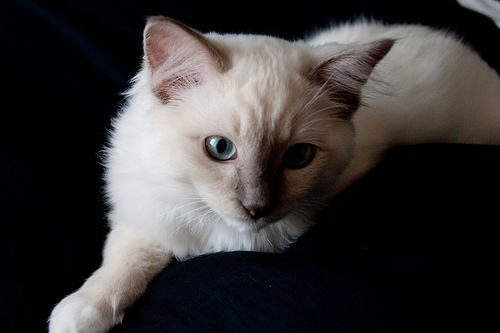

In [17]:
img = PIL.Image.open(fn); img  #take a look at the image

In [18]:
img.size # take a look at the image size

(500, 333)

In [19]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [20]:
row_sz, col_sz = list(zip(*size_d.values()))

In [21]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [22]:
row_sz[:5]

array([500, 500, 300, 300, 330])

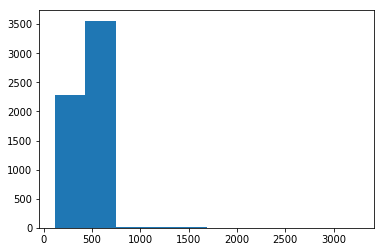

In [23]:
plt.hist(row_sz);

(array([  20.,  192.,  539., 1304.,  259., 3464.,    7.,   45.,   14.,    6.]),
 array([114. , 179.4, 244.8, 310.2, 375.6, 441. , 506.4, 571.8, 637.2, 702.6, 768. ]),
 <a list of 10 Patch objects>)

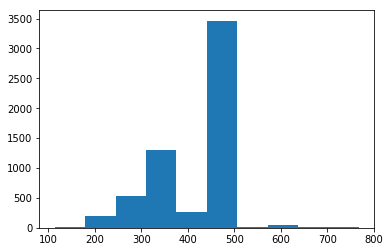

In [24]:
plt.hist(row_sz[row_sz < 800])

(array([2365., 3474.,   17.,   10.,    6.,    3.,    1.,    1.,    1.,    2.]),
 array([ 103. ,  353.3,  603.6,  853.9, 1104.2, 1354.5, 1604.8, 1855.1, 2105.4, 2355.7, 2606. ]),
 <a list of 10 Patch objects>)

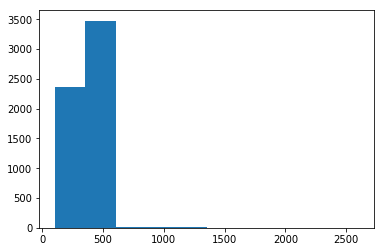

In [25]:
plt.hist(col_sz)

(array([  23.,  391.,  405., 2898.,  324., 1772.,   15.,   13.,    3.,    5.]),
 array([103. , 172.5, 242. , 311.5, 381. , 450.5, 520. , 589.5, 659. , 728.5, 798. ]),
 <a list of 10 Patch objects>)

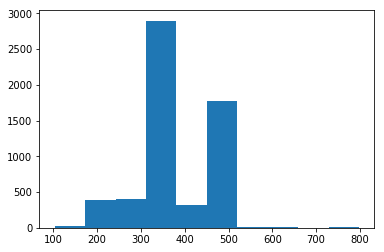

In [26]:
plt.hist(col_sz[col_sz < 800])

In [27]:
len(data.trn_ds), len(data.test_ds)

(5880, 6849)

In [28]:
len(data.classes), data.classes[:5]

(37,
 ['abyssinian',
  'american_bulldog',
  'american_pit_bull_terrier',
  'basset_hound',
  'beagle'])

# Initial model

In [29]:
def get_data(sz, bs): #sz = image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp') # Read jpg and resize to 340 if big, big images slow to process


In [30]:
data = get_data(sz, bs) # use our function to get and precompute the data

In [31]:
learn = ConvLearner.pretrained(arch, data, precompute = True)

In [32]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.497029   0.27481    0.917631  
    1      0.395563   0.282208   0.920354                                                                              
    2      0.315641   0.247425   0.932607                                                                              
    3      0.284774   0.256252   0.920354                                                                              
    4      0.19271    0.256342   0.927161                                                                              



[array([0.25634]), 0.9271613343221302]

## Augment

In [33]:
from sklearn import metrics

In [34]:
data = get_data(sz, bs)

In [35]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [36]:
learn.fit(1e-2,2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.470284   0.296359   0.908101  
    1      0.335275   0.260682   0.914227                                                                              



[array([0.26068]), 0.9142273655750867]

In [37]:
learn.precompute = False

In [38]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.392486   0.23992    0.925119  
    1      0.3405     0.230549   0.925119                                                                              
    2      0.402376   0.236578   0.924438                                                                              
    3      0.27292    0.22478    0.9258                                                                                
    4      0.328684   0.23443    0.925119                                                                              



[array([0.23443]), 0.9251191287401016]

In [39]:
learn.save('224_pretrained_5')

In [40]:
learn.load('224_pretrained_5')

### Increase the size of images

In [41]:
# Started training on small images for some epochs, now switching to bigger images
# continuing training this way is highly effective to avoiding overfitting
learn.set_data(get_data(299,bs))
learn.freeze()

In [42]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

In [43]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.299382   0.200391   0.942138  
    1      0.311466   0.206861   0.934649                                                                              
    2      0.29818    0.207383   0.938053                                                                              



[array([0.20738]), 0.9380530974262827]

In [44]:
# increase cycle time to avoid underfitting as it is too short 
# and getting reset before it could zoomin properly
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) 

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.246226   0.209362   0.939415  
    1      0.223124   0.199313   0.941457                                                                              
    2      0.248323   0.198312   0.942138                                                                              
    3      0.215936   0.20585    0.933288                                                                              
    4      0.181121   0.214784   0.933288                                                                              
    5      0.161989   0.190074   0.939415                                                                              
    6      0.194423   0.194313   0.940776                                                                              



[array([0.19431]), 0.9407760382023208]

In [45]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9387338325391422, 0.17431153942718006)

In [46]:
len(data.val_ds.y), data.val_ds.y[:5]

(1469, array([13,  8, 31, 24, 36], dtype=int64))

In [47]:
learn.save('299_pretrained_5')

In [38]:
learn.load('299_pretrained_5')

In [48]:
data.classes

['abyssinian',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'bengal',
 'birman',
 'bombay',
 'boxer',
 'british_shorthair',
 'chihuahua',
 'egyptian_mau',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'maine_coon',
 'miniature_pinscher',
 'newfoundland',
 'persian',
 'pomeranian',
 'pug',
 'ragdoll',
 'russian_blue',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'siamese',
 'sphynx',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [49]:
data.test_ds.fnames

['test\\0006246bf61f5801e125c305d2ed25e2.jpg',
 'test\\001e73b6915f4128065470cdd3766fcd.jpg',
 'test\\002d5910de023eddce8358edf169c07f.jpg',
 'test\\003b7dec4fe65ec846854c7597617a23.jpg',
 'test\\004955e30603d8c06c1ff917736eb418.jpg',
 'test\\006698c81695d7249438abe28fcc14aa.jpg',
 'test\\0067ecf8de1202baef9064a1bcbce6c3.jpg',
 'test\\0091c20924fb3fe05c1639b19b98fe3f.jpg',
 'test\\00a5981bbe7cdc374385c46792219b90.jpg',
 'test\\00aa13b24da06a2f4ffef1742d2c400d.jpg',
 'test\\00afaa4f2a5e18df354294671081b8c8.jpg',
 'test\\00b79452a6a98c02d9489189b16f5cc8.jpg',
 'test\\00bb022c5622be19209010e94b82cdae.jpg',
 'test\\00bbb23263b12d84fd41f04b83367a7d.jpg',
 'test\\00d1c95ec4752fbeeb372484ca65ffde.jpg',
 'test\\00e5bb8a838164b484caafeb0bc6ffb2.jpg',
 'test\\00f0b3a43e973b3611f06836a2bc6180.jpg',
 'test\\00f3feb014bd7f15ead675f43c7c4664.jpg',
 'test\\011e1e752a5b51e53082cd7f7633db13.jpg',
 'test\\0129e7168fc7a522ffae0fe60b8f0dbf.jpg',
 'test\\013167adb9fbc93923f9c0789599ec95.jpg',
 'test\\01391

In [50]:
log_preds,y = learn.TTA(is_test=True) #use test dataset not validation dataset
probs = np.mean(np.exp(log_preds),0)

In [51]:
probs.shape

(6849, 37)

In [52]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [53]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [54]:
df.head()

,id,abyssinian,american_bulldog,american_pit_bull_terrier,basset_hound,beagle,bengal,birman,bombay,boxer,...,russian_blue,saint_bernard,samoyed,scottish_terrier,shiba_inu,siamese,sphynx,staffordshire_bull_terrier,wheaten_terrier,yorkshire_terrier
0,0006246bf61f5801e125c305d2ed25e2,1.106800e-05,1.741870e-05,2.043111e-05,1.196260e-04,7.854623e-05,2.201960e-08,4.665209e-05,1.092565e-05,2.947102e-03,...,8.459188e-05,9.272044e-06,4.471694e-06,2.930914e-05,8.165162e-05,1.229830e-03,4.509075e-06,3.433742e-03,4.214916e-05,4.249805e-06
1,001e73b6915f4128065470cdd3766fcd,9.831697e-04,5.913597e-08,7.862608e-09,1.955809e-07,5.042343e-08,1.982334e-02,1.547140e-09,6.764253e-06,3.703451e-07,...,1.322799e-03,7.001582e-07,3.398509e-08,8.276302e-07,6.938731e-08,1.562683e-07,1.380667e-04,1.465388e-06,3.519594e-07,7.130817e-06
2,002d5910de023eddce8358edf169c07f,6.010559e-09,5.077866e-06,2.909812e-08,4.048481e-08,9.808955e-09,3.296555e-09,1.269746e-08,1.987566e-07,2.739812e-07,...,7.817168e-07,1.054021e-07,9.999466e-01,4.626559e-07,3.300983e-05,1.886546e-09,9.999269e-09,2.380119e-06,5.190636e-07,2.834579e-09
3,003b7dec4fe65ec846854c7597617a23,1.011014e-06,4.939536e-07,1.978417e-03,8.333740e-07,3.828157e-06,3.777071e-09,6.300637e-09,2.171631e-08,6.903670e-07,...,2.305587e-06,1.458151e-07,6.776202e-09,2.145094e-06,1.730947e-07,7.422891e-08,4.185223e-08,4.480852e-06,4.302161e-07,1.091276e-08
4,004955e30603d8c06c1ff917736eb418,2.654579e-05,1.192871e-08,8.918166e-09,4.745734e-08,1.874940e-07,1.603866e-06,1.463987e-06,9.996995e-01,5.207375e-08,...,2.012190e-04,5.020925e-08,5.740409e-07,9.006870e-07,6.434442e-07,1.434269e-05,9.919442e-08,2.061186e-07,5.799507e-08,5.125738e-07


In [55]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm5.gz', compression='gzip', index=False)

In [56]:
FileLink(f'{SUBM}subm5.gz')

C:\Users\nissan.dookeran\Documents\Github\fastai\courses\dl1\data\dogcatbreed\subm\subm4.gz

Try to find a better learning rate, and do unfreeze() to do fine tuning and differential learning rate annealing

In [57]:
lrf = learn.lr_find()

 67%|█████████████████████████████████████████████▏                      | 489/735 [04:00<02:00,  2.04it/s, loss=0.586]

In [59]:
print(lrf)

None


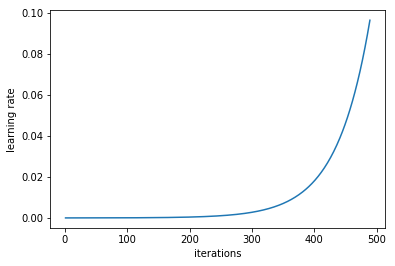

In [60]:
learn.sched.plot_lr()

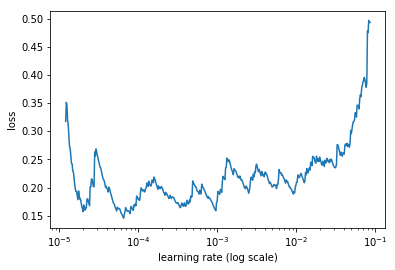

In [61]:
learn.sched.plot()

In [62]:
learn.precompute=False

In [ ]:
learn.fit(1e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.188261   0.192335   0.940095  


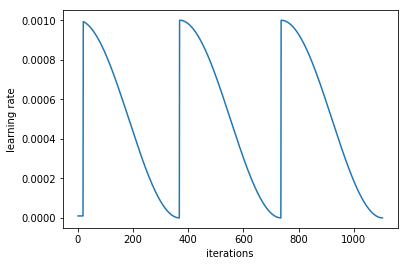

In [29]:
learn.sched.plot_lr()

In [30]:
learn.save('299_lastlayer_5')

In [35]:
learn.load('299_lastlayer_5')

In [36]:
learn.unfreeze()

In [37]:
learn.bn_freeze(True)

In [ ]:
lrf=1e-3

In [38]:
lr=np.array([lrf/9,lrf/3,lrf])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

  0%|                                                                                          | 0/735 [00:00<?, ?it/s]


Steps:
1. Enabled data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is clearly improving
3. Train last layer from pre-computed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle=mult=2 until over-fitting